In [49]:
import itertools
import importlib
import yaml
import sys
import pickle
import multiprocessing as mp
import heapq
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import numpy as np
import math
from fastdtw import fastdtw
import sys

sys.path.insert(0, './code')\
# Local Imports
from TDA import TDA_Parameters, ts_to_tda
from CrossCorrelation import cross_cor
from Metrics import recall_at_k, heap_to_ordered_list, get_value_position
from Preprocess import preprocess
from CastCol import cast_columns

In [50]:
def load(data_file):
    with open(data_file, 'rb') as file:
        traffic = pickle.load(file)
        msgs = pickle.load(file)
    return traffic, msgs
    
def select(data, ip, feature, limit=False):
    traffic = data[0][ip][feature]
    msgs = data[1][ip_to_user(ip)]["count"]
    if limit:
        traffic = limit_range(traffic, msgs)
    return traffic, msgs

import matplotlib.pyplot as plt
def plot_ts(ts,):
    plt.figure(figsize=(8, 4))
    for t in ts:
        for column in t.columns:
            plt.plot(t.index, t[column], label=column)
    
    plt.title('Time Series Plot')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

In [51]:
data_file = "code/dot_all_scopes_https_multiISP_vpn_all_ts.pkl"
ip = "102.0.10.56"
features = ["ip.len_vpn", "count_vpn"]

In [52]:
src, dst = load(data_file)

In [53]:
def ip_to_user(ip, group_size=5, starting=5):
    isp = int(int(ip.split(".")[-2]))
    node_number = int(ip.split(".")[-1]) - starting - isp
    user = node_number % group_size
    group = math.floor(node_number / group_size)
    return '/tordata/config/group_' + str(group) + "_user_" + str(user)

In [54]:
src_ip, dst_ip = src[ip], dst[ip_to_user(ip)]

In [55]:
def compare_ts(ts1, ts2, debug=False):
    # dtw_classic, path_classic = dtw(ts1, ts2, dist='square',
    #                             method='classic', return_path=True)
    # return dtw_classic
    # print(ts1)
    # print(ts2)
    # dist, lag = cross_cor(pd.Series(ts1), pd.Series(ts2))
    dist, lag = cross_cor(ts1, ts2, debug=debug)
    # assert dist >= -1 and dist <= 1
    dist = dist * -1  # flip for use as distance metric
    # assert dist >= -1 and dist <= 1
    return dist, lag
    
def compare_ts_reshape(ts1, ts2, debug=False):
    ts1 = ts1.fillna(0)
    ts2 = ts2.fillna(0)

    range = min(ts2.index.values), max(ts2.index.values)
    ts1 = ts1.loc[(ts1.index >= range[0]) & (ts1.index <= range[1])]

    # ts1 = ts1.loc[:, 'tda_pl']
    ts1 = ts1.values[:, 0]

    ts1_norm = np.array(ts1)
    ts2_norm = np.array(ts2)

    # delay = 0

    # ts1_norm.index = ts1_norm.index + pd.DateOffset(seconds=delay)

    # lock to same range with buffer room
    # on each side to account for network (or PPT) delay

    # detect if no overlap
    if len(ts1_norm) < 2 or len(ts2_norm) < 2:
        return float("inf"), 0

    # Normalize peaks?
    # ts1_norm = normalize_ts(ts1_norm)
    # ts2_norm = normalize_ts(ts2_norm)

    # plot_ts(ts1_norm, ts2_norm)
    # exit(1)

    # else:
    #     ts1_norm = ts1_norm.tolist()
    #     ts2_norm = ts2_norm.tolist()

    score, lag = compare_ts(ts1_norm, ts2_norm, debug=debug)
    adj_score = score + (((lag+1)**1.1)/1000.0)
    return adj_score, lag

In [56]:
def norm(df):
    # Initialize a new DataFrame to store the normalized values
    normalized_df = pd.DataFrame()

    # Loop through each column and normalize it using min-max scaling
    for column in df.columns:
        min_val = df[column].min()
        max_val = df[column].max()
        normalized_values = (df[column] - min_val) / (max_val - min_val)
        normalized_df[column] = normalized_values

    return normalized_df
    
def diff_me(ts):
    return ts.diff().abs()
    
def add_buff(ts, n):
    # Calculate the new timestamp for the last row
    last_timestamp = ts.index[-1]#.timestamp()
    #print(ts.index[-1])
    
    # Create new rows with timestamps in seconds
    new_rows = pd.DataFrame(0, index=pd.date_range(start=last_timestamp, periods=n, freq='S'), columns=ts.columns)
    #print(new_rows)
    # Concatenate the original DataFrame with the new rows
    ts = pd.concat([new_rows, ts, new_rows])
    return ts


def new_tda_2(ts, buff=False):
    ts = ts.fillna(0)
    ts = norm(ts)
    
    dim = 0
    window = 50
    skip = 1
    k = 1
    thresh = float("inf")
    
    params=TDA_Parameters(dim, window, skip, k, thresh)
    if buff:
        ts = add_buff(ts, window+10)
    tda = ts_to_tda(ts, params=params)
    return diff_me(tda)
 
compare_ts_reshape(new_tda_2(src_ip[features]), new_tda_2(dst_ip, buff=True))

(-0.6618239866480096, 62)

In [57]:
dst_ip

,text_len,count
time,,
2023-08-31 10:23:47.500,211,1
2023-08-31 10:23:47.600,0,0
2023-08-31 10:23:47.700,0,0
2023-08-31 10:23:47.800,0,0
2023-08-31 10:23:47.900,0,0
...,...,...
2023-08-31 10:24:44.000,0,0
2023-08-31 10:24:44.100,0,0
2023-08-31 10:24:44.200,0,0


In [58]:
compare_ts_reshape(new_tda_2(src_ip[features]), new_tda_2(dst_ip["text_len"], buff=True))

AttributeError: 'Series' object has no attribute 'columns'

In [47]:
ips = ['102.0.0.72', '102.0.0.83', '102.0.0.80', '102.0.0.43', '102.0.0.17', '102.0.0.46', '102.0.0.19', '102.0.0.51', '102.0.0.28', '102.0.0.10', '102.0.0.77', '102.0.0.76', '102.0.0.44', '102.0.0.74', '102.0.0.95', '102.0.0.24', '102.0.0.37', '102.0.0.49', '102.0.0.109', '102.0.0.94', '102.0.0.73', '102.0.0.96', '102.0.0.27', '102.0.0.92', '102.0.0.85', '102.0.0.36', '102.0.0.47', '102.0.0.71', '102.0.0.69', '102.0.0.34', '102.0.0.30', '102.0.0.102', '102.0.0.14', '102.0.0.21', '102.0.0.81', '102.0.0.12', '102.0.0.88', '102.0.0.91', '102.0.0.39', '102.0.0.90', '102.0.0.103', '102.0.0.38', '102.0.0.35', '102.0.0.105', '102.0.0.65', '102.0.0.100', '102.0.0.99', '102.0.0.52', '102.0.0.45', '102.0.0.11', '102.0.0.20', '102.0.0.57', '102.0.0.82', '102.0.0.78', '102.0.0.61', '102.0.0.16', '102.0.0.106', '102.0.0.93', '102.0.0.55', '102.0.0.62', '102.0.0.33', '102.0.0.25', '102.0.0.13', '102.0.0.86', '102.0.0.50', '102.0.0.40', '102.0.0.26', '102.0.0.58', '102.0.0.67', '102.0.0.89', '102.0.0.75', '102.0.0.59', '102.0.0.68', '102.0.0.60', '102.0.0.23', '102.0.0.79', '102.0.0.87', '102.0.0.70', '102.0.0.41', '102.0.0.108', '102.0.0.54', '102.0.0.97', '102.0.0.15', '102.0.0.64', '102.0.0.84', '102.0.0.104', '102.0.0.22', '102.0.0.31', '102.0.0.98', '102.0.0.66', '102.0.0.101', '102.0.0.107', '102.0.0.32', '102.0.0.48', '102.0.0.42', '102.0.0.18', '102.0.0.53', '102.0.0.29', '102.0.0.63', '102.0.0.56']
users = [ip_to_user(ip) for ip in ips]

In [48]:
results = []
for i in tqdm([s for s in src.keys()]):
    a, b = compare_ts_reshape(new_tda_2(src[i][features]), new_tda_2(dst_ip, buff=True))
    results += [(a, b, i)]
print(sorted(results))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:40<00:00, 27.40s/it]

[(-0.6618239866480096, 62, '102.0.10.56'), (-0.5326612943017129, 140, '102.0.0.65'), (-0.5055852818572084, 216, '102.0.20.87'), (-0.4674733577688907, 24, '102.0.50.90'), (-0.4501252691390425, 22, '102.0.0.25'), (-0.4482397530438404, 5, '102.0.40.59'), (-0.4421283892279446, 96, '102.0.50.80'), (-0.423715936471353, 25, '102.0.40.129'), (-0.39197282851332077, 9, '102.0.20.107'), (-0.38590456766353, 35, '102.0.50.140'), (-0.37763529272729474, 0, '102.0.10.96'), (-0.37301188778807004, 2, '102.0.50.130'), (-0.3532392544778019, 3, '102.0.0.5'), (-0.3500143826126842, 14, '102.0.60.81'), (-0.3441917790007729, 73, '102.0.0.95'), (-0.3374342106485644, 27, '102.0.80.163'), (-0.32267332477531974, 167, '102.0.50.100'), (-0.3165232707119575, 152, '102.0.0.45'), (-0.31250567830281484, 43, '102.0.0.85'), (-0.3010685069117928, 66, '102.0.90.184'), (-0.29206286789840635, 17, '102.0.80.113'), (-0.28558155987321454, 173, '102.0.30.88'), (-0.284049618811772, 29, '102.0.30.48'), (-0.28151514194116634, 100, '

In [27]:
compare_ts_reshape(ts_to_tda(src_ip[features]), ts_to_tda(dst_ip))

(-0.5281090013303676, 566)

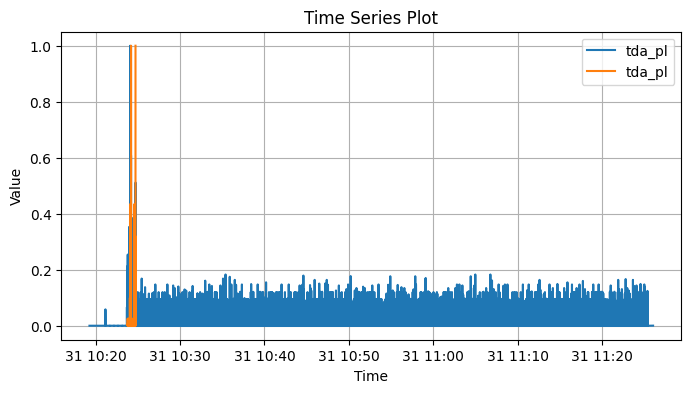

In [28]:
plot_ts([norm(ts_to_tda(src_ip[features])), norm(ts_to_tda(dst_ip))])

In [29]:
def plot_ts_m(df, rev=False):
    plt.figure(figsize=(8, 4))

    cols = df.columns
    if rev:
        cols = reversed(cols)
    
    for column in cols:
        plt.plot(df.index, df[column], label=column)
    
    plt.title('Multiple Columns on the Same Graph')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

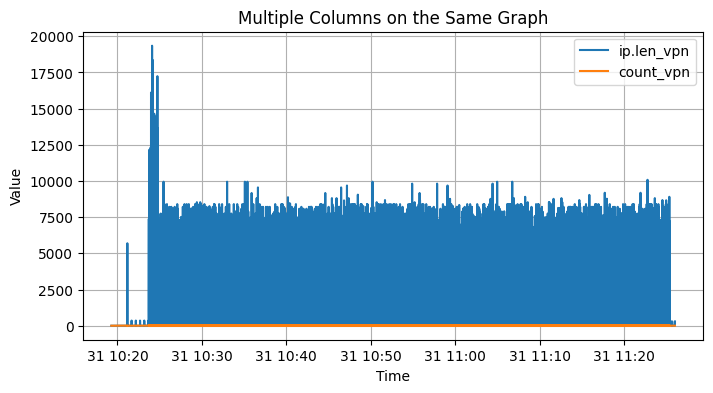

In [30]:
df = src_ip[features]
plot_ts_m(df)

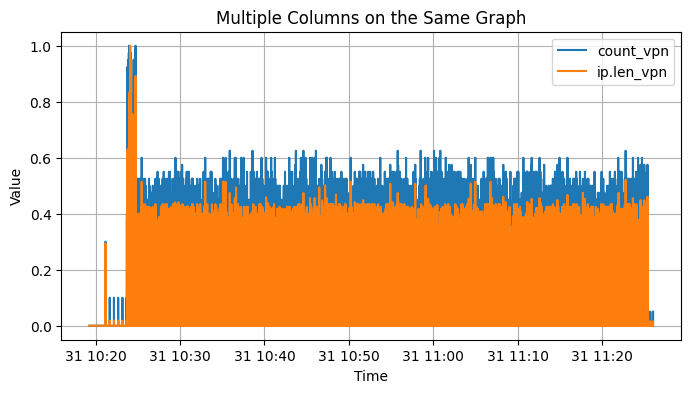

In [32]:
df_norm = norm(src_ip[features].copy())
plot_ts_m(df_norm, rev=True)

In [33]:
diff = pd.DataFrame(df_norm["ip.len_vpn"]-df_norm["count_vpn"])

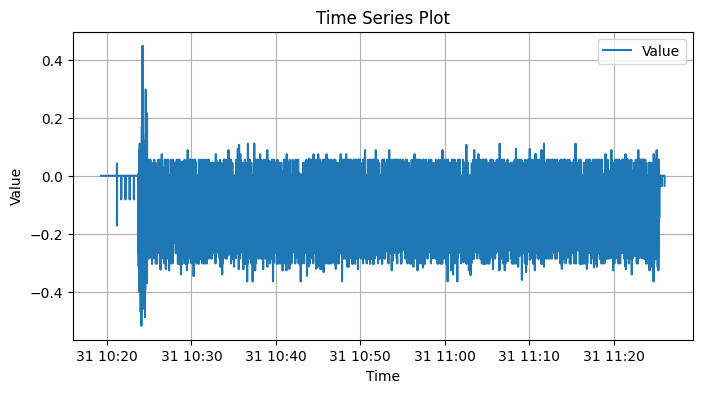

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(diff.index, diff, label='Value')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

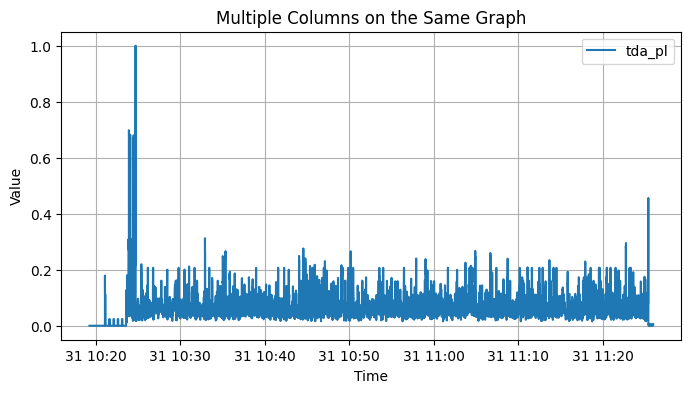

In [35]:
def new_tda(ts):
    dim = 0
    window = 40
    skip = 1
    k = 1
    thresh = float("inf")
    
    params=TDA_Parameters(dim, window, skip, k, thresh)
    tda = ts_to_tda(ts, params=params)
    return tda
tda_old = new_tda(df_norm)
plot_ts_m(norm(tda_old))

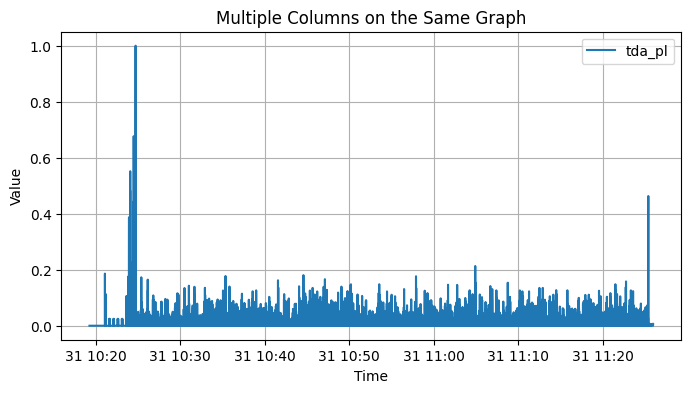

In [37]:

tda_diff = diff_me(tda_old)
plot_ts_m(norm(tda_diff))

In [207]:
#user = new_tda(dst_ip)
#user_diff = diff_me(user)
compare_ts_reshape(tda_diff, diff_me(user_old))

(-0.43330014205671424, 532)

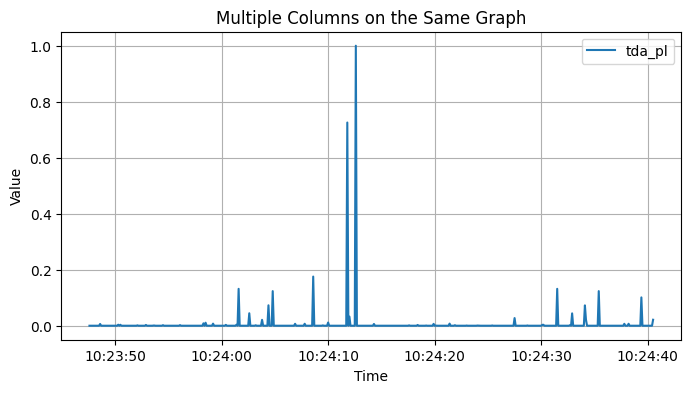

In [131]:
plot_ts_m(norm(user_diff))

In [112]:
def limit_range(ts1, ts2):
    range = min(ts2.index.values), max(ts2.index.values)
    ts1 = ts1.loc[(ts1.index >= range[0]) & (ts1.index <= range[1])]
    return ts1

In [123]:
l_me = pd.DataFrame(dst_ip["text_len"])

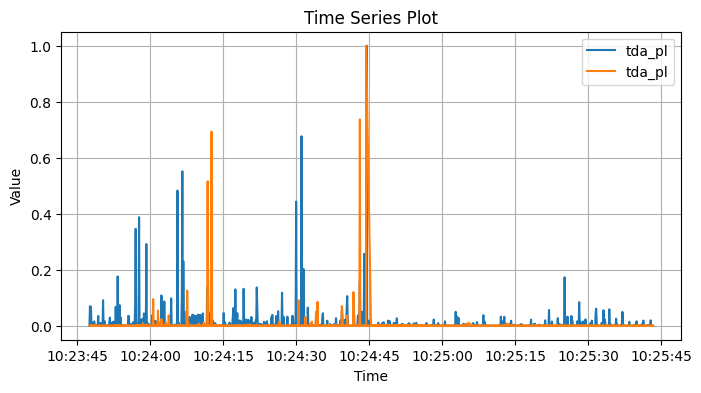

In [227]:
l_tda_diff = limit_range(tda_diff, user_old)
plot_ts([norm(l_tda_diff), norm(diff_me(user_old))])#, norm(user_diff), norm(l_me)])